In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import os
import torchvision
import torch

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.is_available() # Use gpu


False

In [3]:

# Creating a custom image dataset
# To apply image argumentation to each image
class SkinCancerDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transformation=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
    
    def __len__(self):
        return 1

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_segmentation.png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [20]:
# Create a sequential of transformation
transform = A.Compose(
        [
            A.Resize(height=90, width=90),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

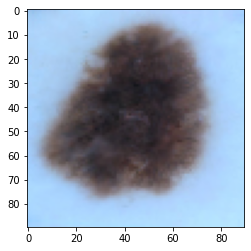

In [42]:
# Apply the transformation to datasets
training = SkinCancerDataset("/content/images/", "/content/masks/", transformation=transform)
x = training[0][0]
x = x.T
plt.imshow(x)

In [43]:
# """ Convolutional block:
#     It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
# """
# class conv_block(nn.Module):
#     def __init__(self, in_c, out_c):
#         super().__init__()

#         self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(out_c)

#         self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(out_c)

#         self.relu = nn.ReLU()

#     def forward(self, inputs):
#         x = self.conv1(inputs)
#         x = self.bn1(x)
#         x = self.relu(x)

#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)

#         return x

# """ Encoder block:
#     It consists of an conv_block followed by a max pooling.
#     Here the number of filters doubles and the height and width half after every block.
# """
# class encoder_block(nn.Module):
#     def __init__(self, in_c, out_c):
#         super().__init__()

#         self.conv = conv_block(in_c, out_c)
#         self.pool = nn.MaxPool2d((2, 2))

#     def forward(self, inputs):
#         x = self.conv(inputs)
#         p = self.pool(x)

#         return x, p

# """ Decoder block:
#     The decoder block begins with a transpose convolution, followed by a concatenation with the skip
#     connection from the encoder block. Next comes the conv_block.
#     Here the number filters decreases by half and the height and width doubles.
# """
# class decoder_block(nn.Module):
#     def __init__(self, in_c, out_c):
#         super().__init__()

#         self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
#         self.conv = conv_block(out_c+out_c, out_c)

#     def forward(self, inputs, skip):
#         x = self.up(inputs)
#         x = torch.cat([x, skip], axis=1)
#         x = self.conv(x)

#         return x


# class UNet(nn.Module):
#     def __init__(self):
#         super().__init__()

#         """ Encoder """
#         self.e1 = encoder_block(3, 64)
#         self.e2 = encoder_block(64, 128)
#         self.e3 = encoder_block(128, 256)
#         self.e4 = encoder_block(256, 512)

#         """ Bottleneck """
#         self.b = conv_block(512, 1024)

#         """ Decoder """
#         self.d1 = decoder_block(1024, 512)
#         self.d2 = decoder_block(512, 256)
#         self.d3 = decoder_block(256, 128)
#         self.d4 = decoder_block(128, 64)

#         """ Classifier """
#         self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

#     def forward(self, inputs):
#         """ Encoder """
#         s1, p1 = self.e1(inputs)
#         s2, p2 = self.e2(p1)
#         s3, p3 = self.e3(p2)
#         s4, p4 = self.e4(p3)

#         """ Bottleneck """
#         b = self.b(p4)

#         """ Decoder """
#         d1 = self.d1(b, s4)
#         d2 = self.d2(d1, s3)
#         d3 = self.d3(d2, s2)
#         d4 = self.d4(d3, s1)

#         """ Classifier """
#         outputs = self.outputs(d4)

#         return outputs
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [44]:
# code from my CSC311 Lab

def train(model,
          train_data,
          # valid_data,
          batch_size=20,
          learning_rate=0.001,
          weight_decay=0.0,
          num_iter=1000, plot=False):

    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)

    criterion = nn.BCEWithLogitsLoss()

    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    # Set the model to use the GPU if it is available
    if torch.cuda.is_available():
        model.cuda()
        criterion.cuda()

    # Instantiate a few Python lists to track the learning curve
    iters, losses, train_acc, val_acc = [], [], [], []

    n = 0 # tracks the number of iterations
    while n < num_iter:
        for imgs, labels in iter(train_loader): # (imgs, labels) is a minibatch
            if n >= num_iter: 
                break
            if imgs.size()[0] < batch_size:
                continue

            # If using the GPU, we need to move the images and labels to the GPU:
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model.forward(imgs) # Forward pass. Also can call model(imgs)
            labels = labels.float().unsqueeze(1).to(device=DEVICE)
            loss = criterion(out, labels) # Compute the loss
            loss.backward() # Compute the gradients (like in lab 5)
            optimizer.step() # Like the update() method in lab 5
            optimizer.zero_grad() # Like the cleaup() method in lab 5

            # Save the current training information
            if plot:
                iters.append(n)
                losses.append(float(loss)/batch_size)             # compute *average* loss

            # Increment the iteration count
            n += 1

    if plot:
        plt.title("Learning Curve")
        plt.plot(iters, losses, label="Train")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

    return losses[-1]

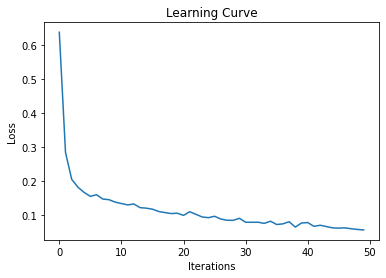

0.056303296238183975

In [45]:
model = UNET()
train(model, training, batch_size=1, learning_rate=0.001, weight_decay=0.0, num_iter=50, plot=True)

In [46]:
train_loader = torch.utils.data.DataLoader(training,
                                               batch_size=1,
                                               shuffle=True)
prediction = None
groundtruth = None
for imgs, labels in iter(train_loader):
  prediction = torch.sigmoid(model.forward(imgs))
  prediction = (prediction > 0.5).float()
  groundtruth = labels

pred = np.squeeze(prediction.detach().numpy())
groundtruth =  np.squeeze(groundtruth.detach().numpy())

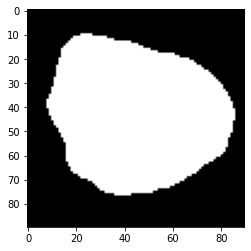

In [47]:
plt.imshow(pred, 'gray')

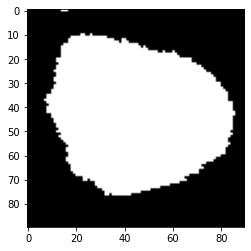

In [48]:
plt.imshow(groundtruth, 'gray')